### Imports

In [22]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.cluster import KMeans 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, mutual_info_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import time
from genetic_selection import GeneticSelectionCV
import warnings
warnings.filterwarnings("ignore")

### Loading data and filtering to two main classes for PoC

In [2]:
main = pd.read_csv("main_df.csv")
reliable = main[main.type == "reliable" ]
fake = main[main.type == "fake" ]
data = pd.concat([fake, reliable])

### Encoding

In [3]:
count = CountVectorizer()
X_count = count.fit_transform(data.content)
hash = HashingVectorizer()
X_hash = hash.fit_transform(data.content)
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_count)

### Modelling

In [11]:
def test_model(m, gefes=True):
    encoders = []
    times = []
    names = []
    accuracies = []
    recalls = []
    f1 = []
    enc = ["CountVectorizer", "HashingVectorizer","TfidfTransformer"]
    x_list = [X_count, X_hash, X_tfidf]
    for i in range(3):
        X = x_list[i]
        
        encoder = enc[i]

        y = data.type=="fake"
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        start = time.time()
        # finding clusters of features
        x_t = np.transpose(X_train)
        kmeans = KMeans(n_clusters = 100)
        clusters = kmeans.fit_predict(X_train)

        # calculating correlation to target variable
        correlation= [mutual_info_score((x_t[j].toarray())[0], y_train) for j in range(x_t.shape[1])]

        # choosing the best feature from each cluster
        predictors = []
        for c in np.unique(clusters):
            corr = [correlation[j] if clusters[i]==c else 0 for j in range(len(clusters))]
            predictors.append(np.where(corr == np.max(corr))[0][0])

        # model
        X_train = np.transpose(x_t[predictors])
        X_test = np.transpose((np.transpose(X_test))[predictors])
        svm = m()
        svm.fit(X_train, y_train)
        pred2 = svm.predict(X_test)
        end = time.time()
        times.append(start-time.time())
        names.append("kmeans FS")
        accuracies.append(accuracy_score(y_test, pred2))
        recalls.append(recall_score(y_test, pred2))
        f1.append(f1_score(y_test, pred2))
        if gefes:
            #GeFES
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
            start = time.time()
            clf = m()
            model = GeneticSelectionCV(
                clf, cv=5, verbose=0,
                scoring="accuracy", max_features=10,
                n_population=100, crossover_proba=0.5,
                mutation_proba=0.2, n_generations=50,
                crossover_independent_proba=0.5,
                mutation_independent_proba=0.04,
                tournament_size=3, n_gen_no_change=10,
                caching=True, n_jobs=-1)
            model = model.fit(X_train, y_train)
            pred2 = model.predict(X_test)
            times.append(start-time.time())
            names.append("gefes")
            accuracies.append(accuracy_score(y_test, pred2))
            recalls.append(recall_score(y_test, pred2))
            f1.append(f1_score(y_test, pred2))
        
        # baseline model without feaature selection
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        start = time.time()
        svm2 = m()
        svm2.fit(X_train, y_train)
        pred2 = svm2.predict(X_test)
        times.append(start-time.time())
        names.append("Full model")
        accuracies.append(accuracy_score(y_test, pred2))
        recalls.append(recall_score(y_test, pred2))
        f1.append(f1_score(y_test, pred2))
        
        for _ in range(3 if gefes else 2):
            encoders.append(encoder)
            
    results = pd.DataFrame(data={"Encoder":encoders, "Model":names, "Accuracy": accuracies, "Recall":recalls, "F1":f1, "time":times})
    return results

## SVM

In [7]:
test_model(SVC)

a
a
a
a
a
a
a
a
a


,Encoder,Model,Accuracy,Recall,F1,time
0,CountVectorizer,kmeans FS,0.753030,0.996923,0.799014,-58.393619
1,CountVectorizer,gefes,0.668182,0.993846,0.746821,-195.611084
2,CountVectorizer,Full model,0.859091,0.947692,0.868829,-2.436263
3,HashingVectorizer,kmeans FS,0.637879,0.953846,0.721769,-402.022400
4,HashingVectorizer,gefes,0.493939,0.966154,0.652807,-3888.110079
5,HashingVectorizer,Full model,0.916667,0.953846,0.918519,-2.125993
6,TfidfTransformer,kmeans FS,0.539394,0.587692,0.556851,-26.335958
7,TfidfTransformer,gefes,0.621212,0.741538,0.658470,-222.282773
8,TfidfTransformer,Full model,0.906061,0.956923,0.909357,-3.336636


## Passive agressive

In [10]:
test_model(PassiveAggressiveClassifier)

a
a
a
a
a
a


,Encoder,Model,Accuracy,Recall,F1,time
0,CountVectorizer,kmeans FS,0.507576,0.000000,0.000000,-29.952430
1,CountVectorizer,Full model,0.927273,0.929231,0.926380,-0.022416
2,HashingVectorizer,kmeans FS,0.509091,0.003077,0.006135,-403.129258
3,HashingVectorizer,Full model,0.933333,0.975385,0.935103,-0.079544
4,TfidfTransformer,kmeans FS,0.507576,0.000000,0.000000,-32.282761
5,TfidfTransformer,Full model,0.939394,0.972308,0.940476,-0.012000


# Multilabel

Without feature selection as standard model trains fast enough

Time: 176.7836537361145


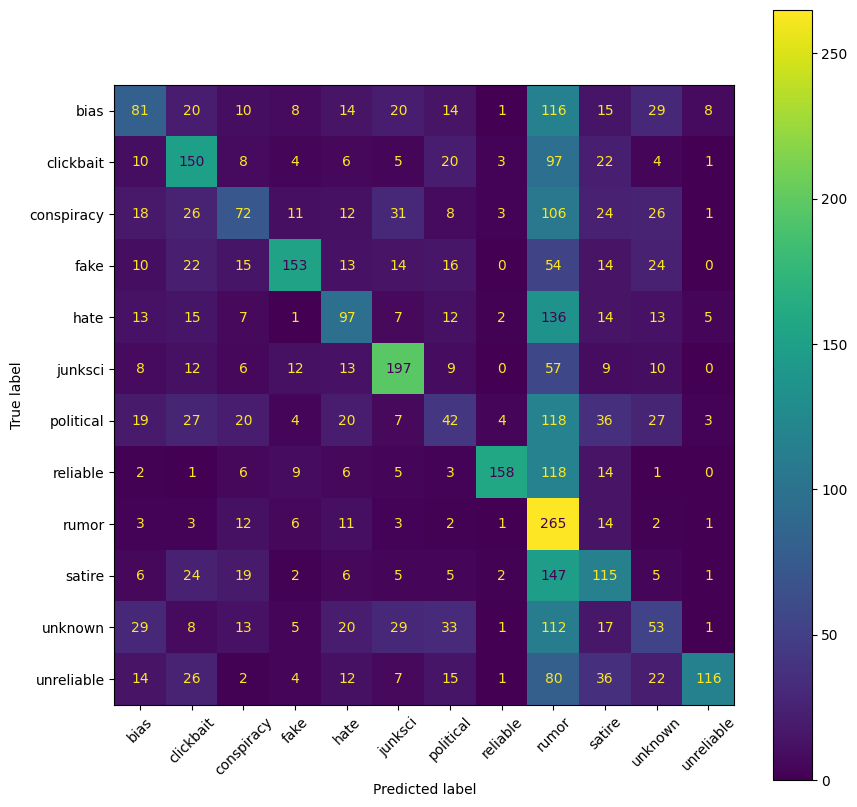

In [33]:

# Encodeing
count = CountVectorizer()
X = count.fit_transform(main.content)
y = main.type

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Modeling
start = time.time()
svm2 = SVC()
svm2.fit(X_train, y_train)

#Prediction
pred2 = svm2.predict(X_test)

#Results
print(f"Time: {-start+time.time()}") 
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay(confusion_matrix(y_test, pred2, labels=svm2.classes_), display_labels=svm2.classes_).plot(ax=ax, xticks_rotation=45)
